# Facial Expression Recognition

## Initialisation

In [5]:
!pip install fastai
from fastai.vision.all import *

# Define the path
path = Path("/kaggle/input/affectnet-yolo/DATA/train/images")
label_path = Path("/kaggle/input/affectnet-yolo/DATA/train/labels")
model_dir = '/kaggle/working/models'

# Map numbers to labels
expressions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

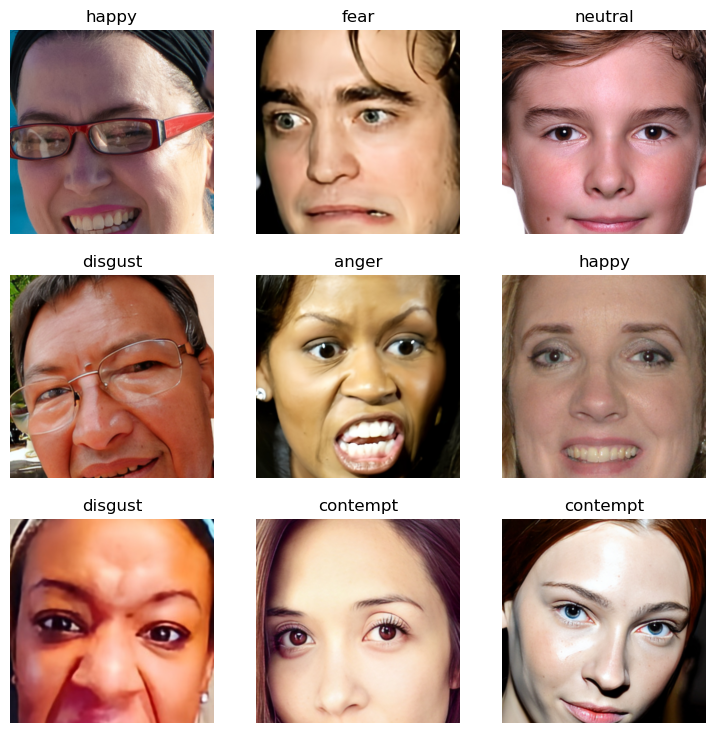

In [2]:
# Create a dictionary of labels
labels_dict = {}
for txt_file in label_path.glob('*.txt'):
    with open(txt_file) as f:
        content = f.read().strip().split()
        label_index = int(content[0]) # Assuming the class is the first element in the file
        label = expressions[label_index]
        filename = txt_file.stem # Filename without extension
        labels_dict[filename] = label

# Define the labeling function
def label_func(filepath):
    filename = filepath.stem
    return labels_dict.get(filename, 'unknown') # Return 'unknown' if the filename is not found in the dictionary

# Gather the file paths
files = get_image_files(path)

# Define any data augmentation or preprocessing
item_tfms = Resize(460)
batch_tfms = aug_transforms(size=224)

# Create the ImageDataLoaders object
faces = ImageDataLoaders.from_path_func(
    path, files, label_func, 
    item_tfms=item_tfms, 
    #! this will not run on m1 mac
    # batch_tfms=batch_tfms
)

faces.show_batch()

SuggestedLRs(valley=0.0008317637839354575)

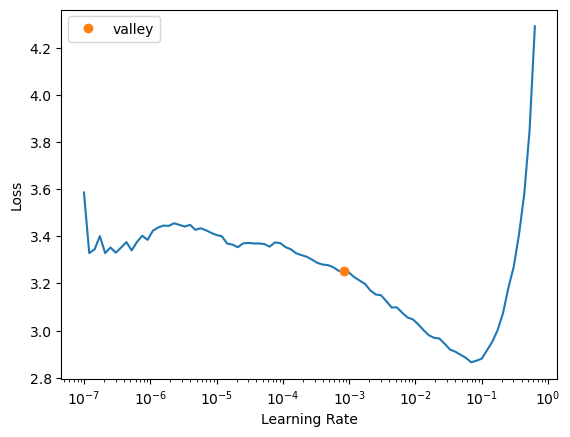

In [7]:
# create a learner
learn = vision_learner(faces, resnet34, metrics=error_rate, model_dir=model_dir)
learn.lr_find() # find the optimal learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.901130,1.348056,0.499608,10:32


epoch,train_loss,valid_loss,error_rate,time
0,1.302885,1.030472,0.386755,10:58
1,1.065884,0.935016,0.349726,10:43


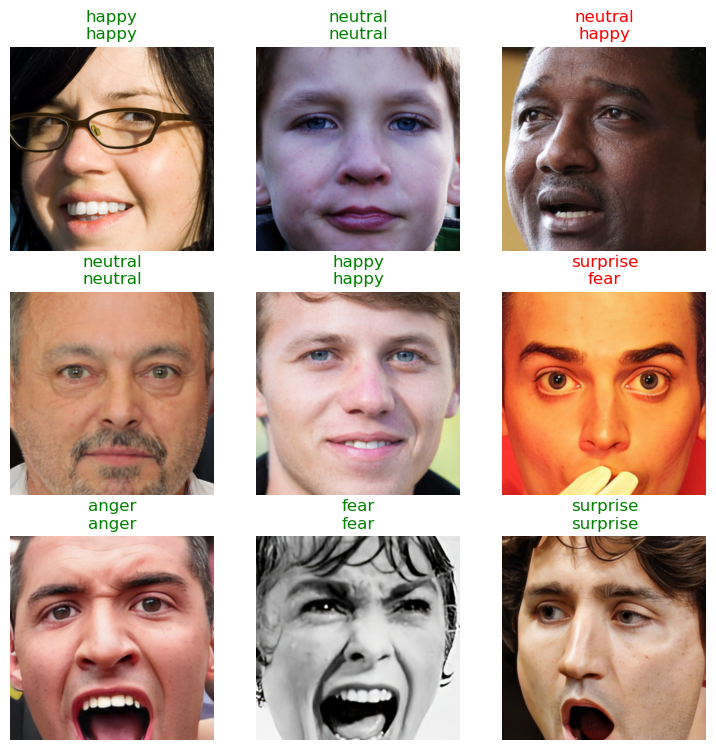

In [8]:
learn.fine_tune(2, 8e-4) # train the model
learn.show_results() # check the results

In [ ]:
# refine
# export the model